In [88]:
import ROOT as rt
import array as arr
import math

In [2]:
TRIG_PT_LOW = 4
TRIG_PT_HIGH = 8
ASSOC_PT_LOW = 2
ASSOC_PT_HIGH = 4

In [3]:
c = rt.TCanvas("main_canvas", "Main Canvas", 0, 10, 1920, 1080)

In [4]:
def make_mixed_corrections(same_dist, mixed_dist, mass_low=1.11, mass_high=1.12, is_hh=False):
    if is_hh:
        same3d = same
        same3d.Sumw2()
        mixed3d = mixed
        mixed3d.Sumw2()
    else:
        same.GetAxis(2).SetRangeUser(mass_low, mass_high)
        mixed.GetAxis(2).SetRangeUser(mass_low, mass_high)
        same3d = same.Projection(0, 1, 3)
        same3d.Sumw2()
        mixed3d = mixed.Projection(0, 1, 3)
        mixed3d.Sumw2()
        
    for zbin in range(10):
        same3d.GetZaxis().SetRange(zbin+1, zbin+1)
        same2d = same3d.Project3D("xye")
        same2d.SetName(f"same2dproj_zbin_{zbin}")

        mixed3d.GetZaxis().SetRange(zbin+1, zbin+1)
        mixed2d = mixed3d.Project3D("xye")
        mixed2d.SetName(f"mix2dproj_zbin_{zbin}")

        #scaling by average of bins adjacent to 0
        scale = 0.5*(mixed2d.Integral(mixed2d.GetXaxis().FindBin(-0.01),    #xmin
                                      mixed2d.GetXaxis().FindBin(0.01),     #xmax 
                                      mixed2d.GetYaxis().FindBin(0.0),      #ymin
                                      mixed2d.GetYaxis().FindBin(0.0)))     #ymax
        same2d.Divide(mixed2d)
        same2d.Scale(scale)
        
        if zbin == 0:
            same2d_total = same2d.Clone("2dproj_total")
        else:
            same2d_total.Add(same2d)

    return same2d_total
    

# 0-20 setup

In [ ]:
input_file_cent_0_20 = rt.TFile("../online/output/cent_0_20.root")

# 20 - 50 setup

In [5]:
input_file_20_50 = rt.TFile("../online/output/cent_20_50-1.root")
input_list_20_50 = input_file_20_50.Get("h-lambda")
input_file_20_50.Close()

In [6]:
trig_dist_20_50 = input_list_20_50.FindObject("fTriggerDist")
lambda_dist_20_50 = input_list_20_50.FindObject("fTriggeredLambdaDist")

In [7]:
h_h_20_50 = input_list_20_50.FindObject("fDphiHHEff")
h_h_mixed_20_50 = input_list_20_50.FindObject("fDphiHHMixed")

In [8]:
h_lambda_20_50 = input_list_20_50.FindObject("fDphiHLambdaEff")
h_lambda_ls_20_50 = input_list_20_50.FindObject("fDphiHLambdaLS")
h_lambda_mixed_20_50 = input_list_20_50.FindObject("fDphiHLambdaMixed")
h_lambda_ls_mixed_20_50 = input_list_20_50.FindObject("fDphiHLambdaLSMixed")

In [9]:
# Setting the trigger Pt (this is never changed again)
trig_dist_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [10]:
# Setting the associated Pt (this is never changed again)
lambda_dist_20_50.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_mixed_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [26]:
trig_pt_dist_20_50 = trig_dist_20_50.Projection(0).Clone("trig_pt_dist_20_50")
trig_phi_dist_20_50 = trig_dist_20_50.Projection(1).Clone("trig_phi_dist_20_50")
trig_eta_dist_20_50 = trig_dist_20_50.Projection(2).Clone("trig_eta_dist_20_50")

trig_pt_dist_20_50.SetTitle("Trigger #font[12]{p}_{T} Distribution (Hybrid GCG)")
trig_pt_dist_20_50.Sumw2()
trig_pt_dist_20_50.SetLineColor(rt.kRed)

trig_phi_dist_20_50.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_20_50.Sumw2()
trig_phi_dist_20_50.SetLineColor(rt.kRed)

trig_eta_dist_20_50.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_20_50.Sumw2()
trig_eta_dist_20_50.SetLineColor(rt.kRed)

Warning in <TROOT::Append>: Replacing existing TH1: fTriggerDist_proj_0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fTriggerDist_proj_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fTriggerDist_proj_2 (Potential memory leak).


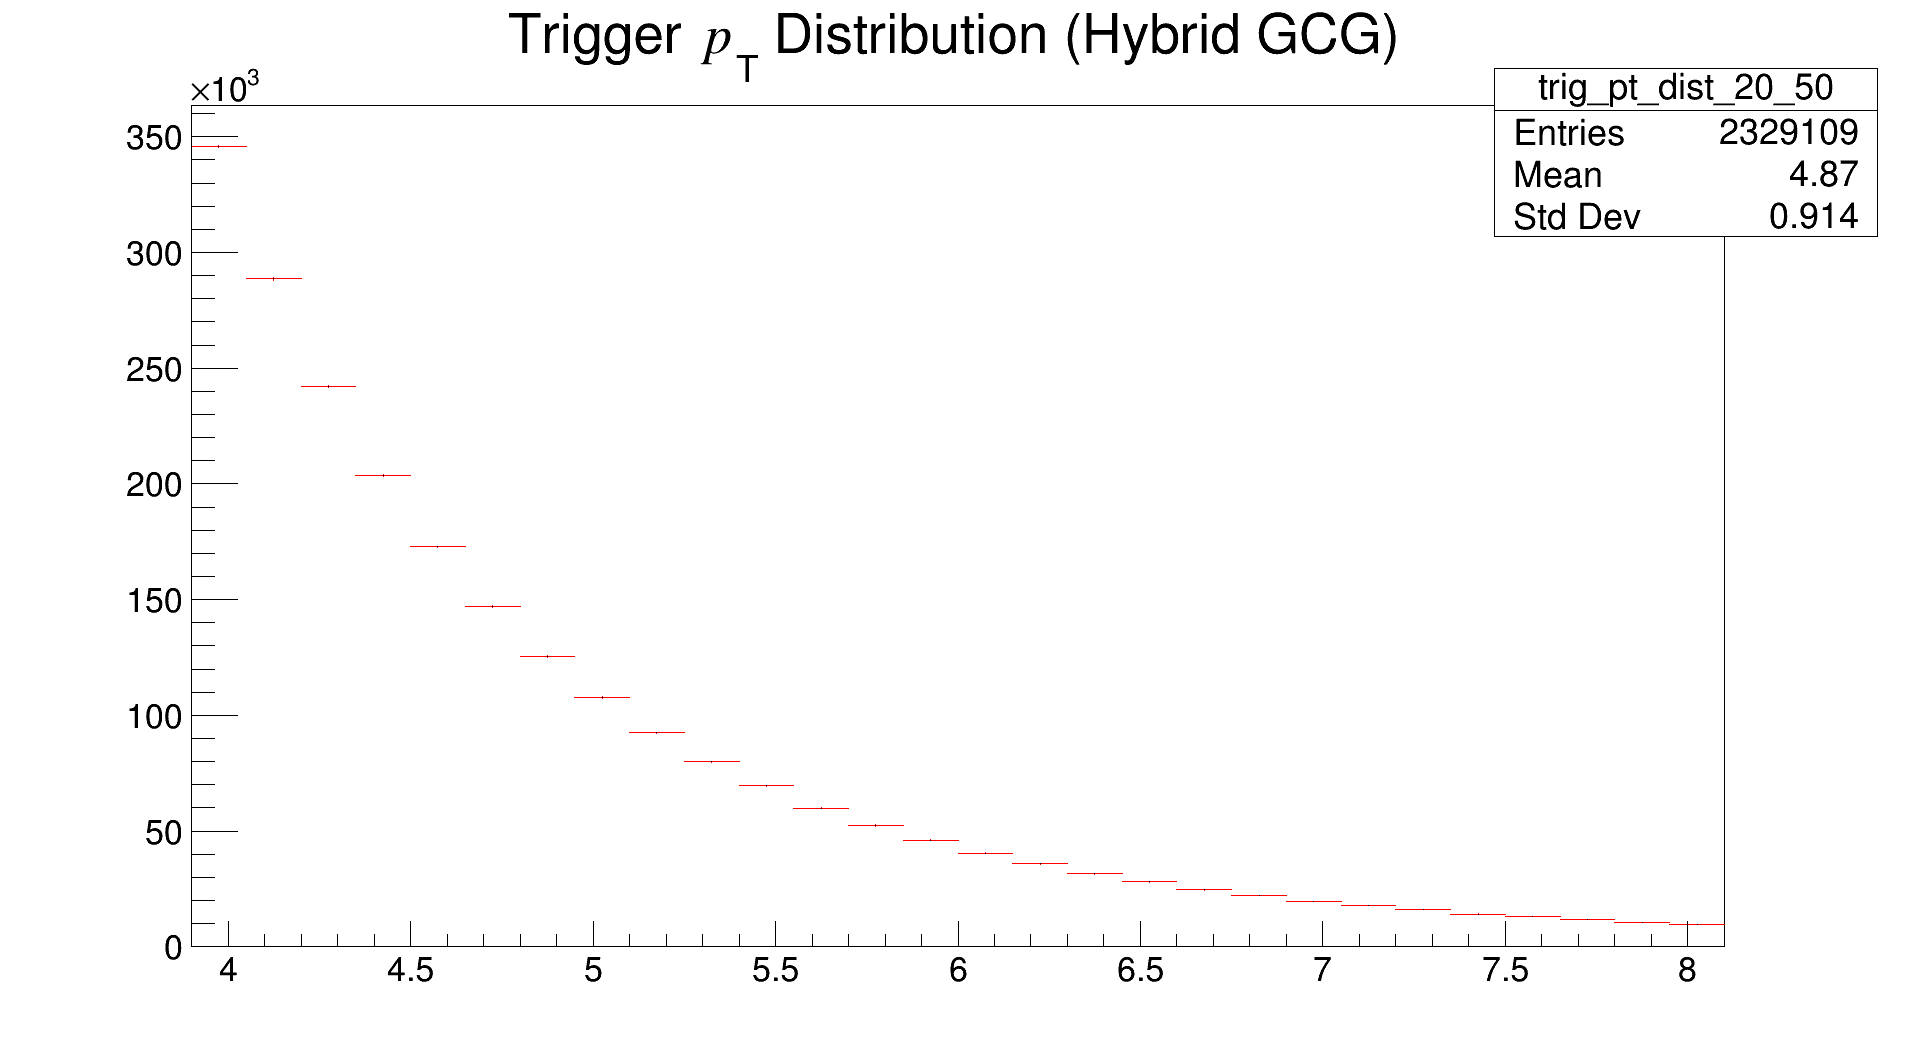

In [27]:
trig_pt_dist_20_50.Draw()
c.Draw()

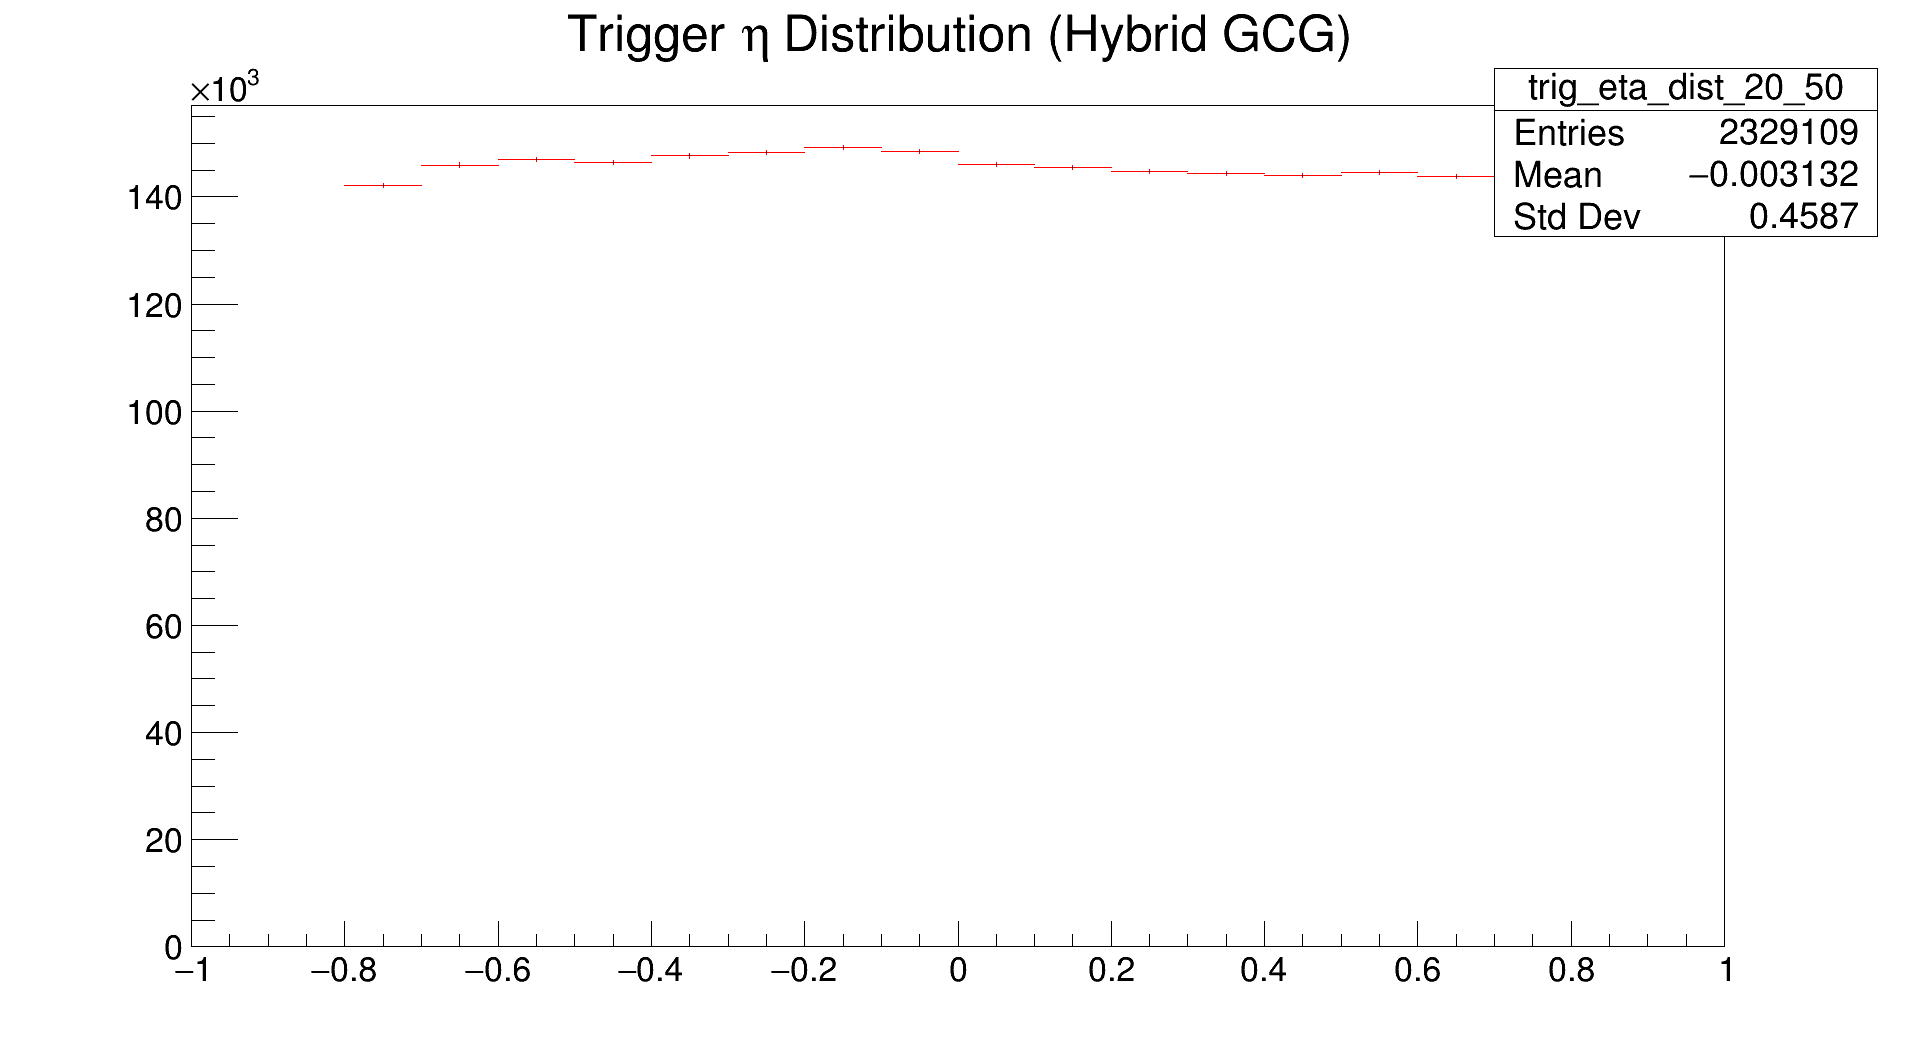

In [16]:
trig_eta_dist_20_50.Draw()
c.Draw()

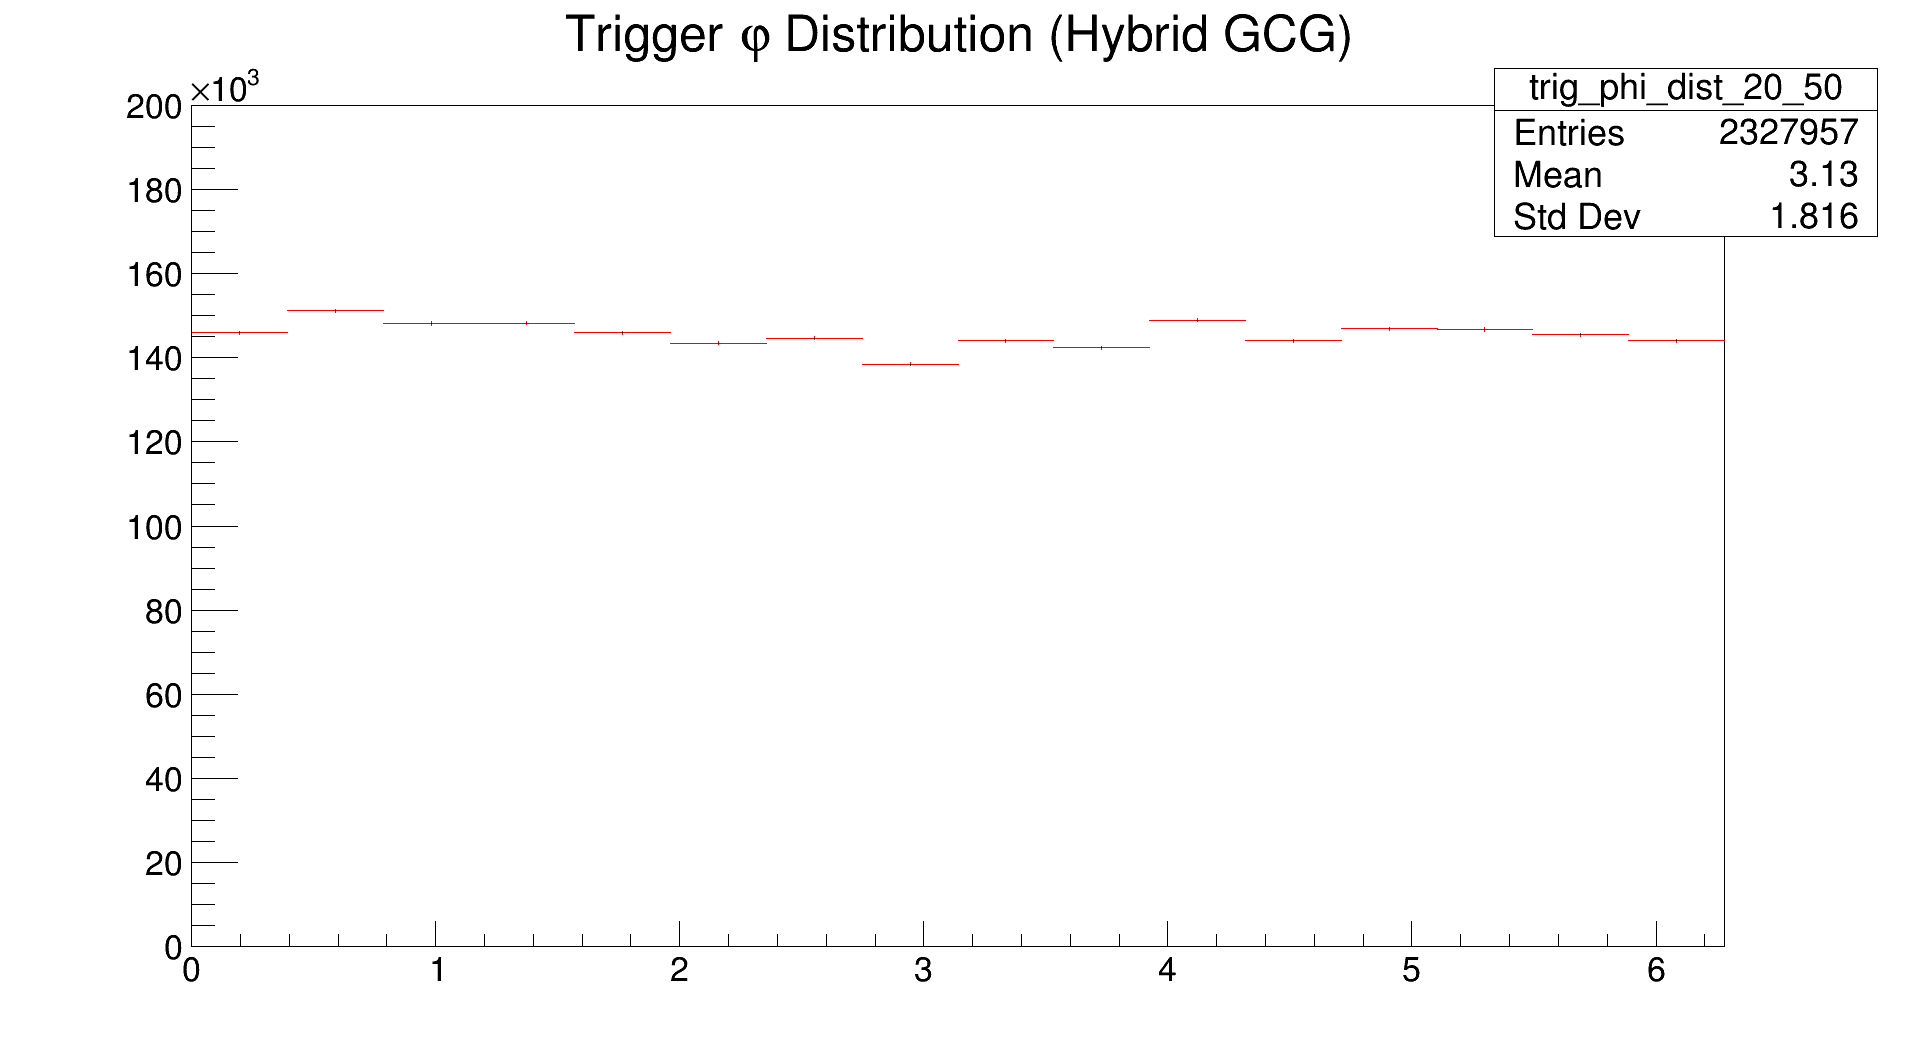

In [19]:
trig_phi_dist_20_50.GetYaxis().SetRangeUser(0, 200e3)
trig_phi_dist_20_50.Draw()
c.Draw()

In [52]:
# eta cuts first
lambda_dist_20_50.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_mass_dist_20_50 = lambda_dist_20_50.Projection(3).Clone("lambda_mass_dist_20_50")

Warning in <TROOT::Append>: Replacing existing TH1: fTriggeredLambdaDist_proj_3 (Potential memory leak).


In [53]:
lambda_mass_dist_20_50.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist_20_50.Sumw2()
lambda_mass_dist_20_50.Rebin(2)
lambda_mass_dist_20_50.SetLineWidth(2)
lambda_mass_dist_20_50.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist_20_50.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

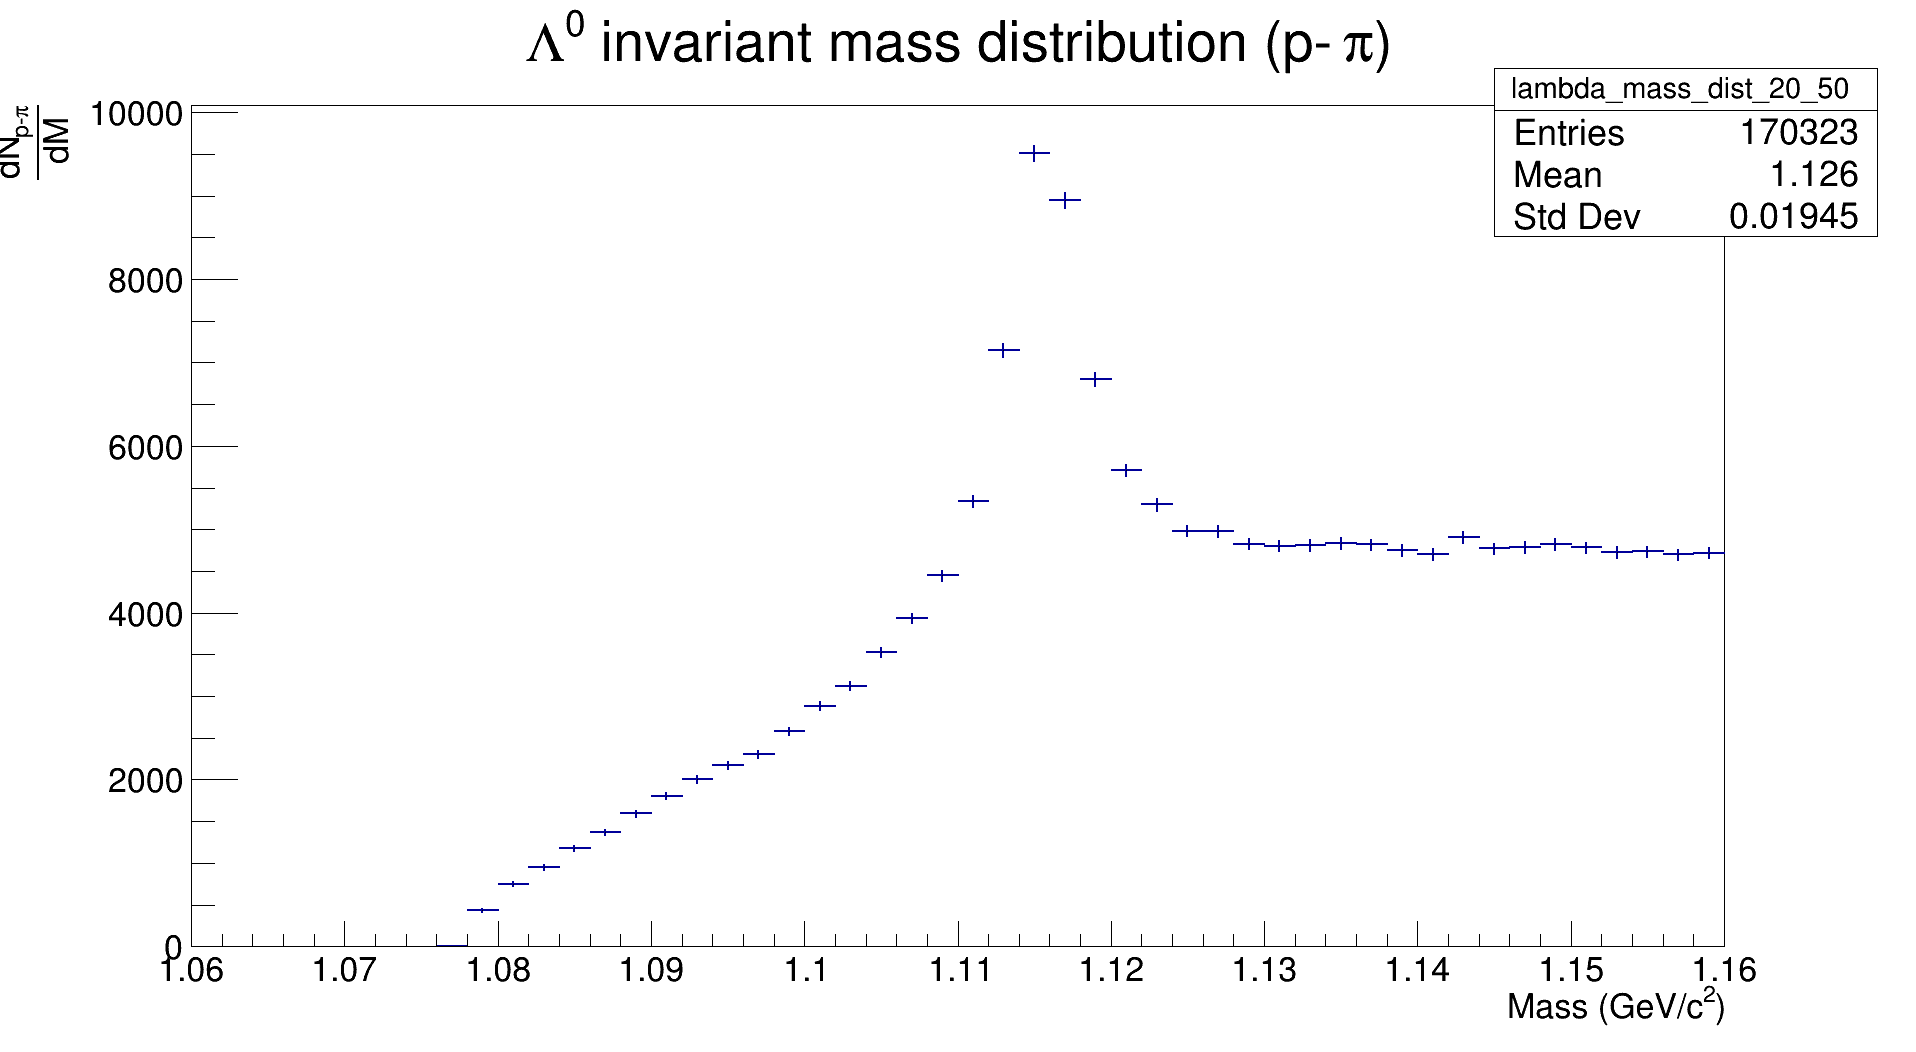

In [54]:
lambda_mass_dist_20_50.Draw()
c.Draw()

In [61]:
lambda_mass_fit_20_50 = rt.TF1("lambda_mass_fit_20_50", "[0]*TMath::Voigt(x - [1], [2], [3], 4) + pol2(4)", 1.09, 1.15)
lambda_mass_fit_20_50.SetNpx(1000)
lambda_mass_fit_20_50.SetParameter(0, 1.36753e01)
lambda_mass_fit_20_50.SetParameter(1, 1.11581)
lambda_mass_fit_20_50.SetParameter(2, 1.00576e-05 )
lambda_mass_fit_20_50.SetParameter(3, 6.04166e-03)
lambda_mass_fit_20_50.SetParameter(4, -23990621/21)
lambda_mass_fit_20_50.SetParameter(5, 1997000)
lambda_mass_fit_20_50.SetParameter(6, -18250000/21)

In [62]:
bin_1 = lambda_mass_dist_20_50.FindBin(1.09)
bin_2 = lambda_mass_dist_20_50.FindBin(1.15)
bin_3 = lambda_mass_dist_20_50.FindBin(1.16 - 0.0001)
print(lambda_mass_dist_20_50.GetBinContent(bin_1))
print(lambda_mass_dist_20_50.GetBinContent(bin_2))
print(lambda_mass_dist_20_50.GetBinContent(bin_3))

1804.0
4824.0
4719.0


 FCN=187.776 FROM MIGRAD    STATUS=FAILED        864 CALLS         865 TOTAL
                     EDM=7.10612e-05    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.88480e+01   1.12078e+00  -0.00000e+00  -4.96227e-04
   2  p1           1.11569e+00   4.13079e-05  -0.00000e+00  -1.26348e+00
   3  p2           4.05553e-08   8.88926e-14   0.00000e+00  -7.35134e+10
   4  p3           6.27548e-03   1.37270e-04   0.00000e+00   4.47198e+00
   5  p4          -1.30805e+06   2.11366e+04  -0.00000e+00   3.76536e-06
   6  p5           2.29056e+06   3.81127e+04   0.00000e+00   4.17512e-06
   7  p6          -9.99124e+05   1.71662e+04  -0.00000e+00   4.63337e-06


Warning in <Fit>: Abnormal termination of minimization.


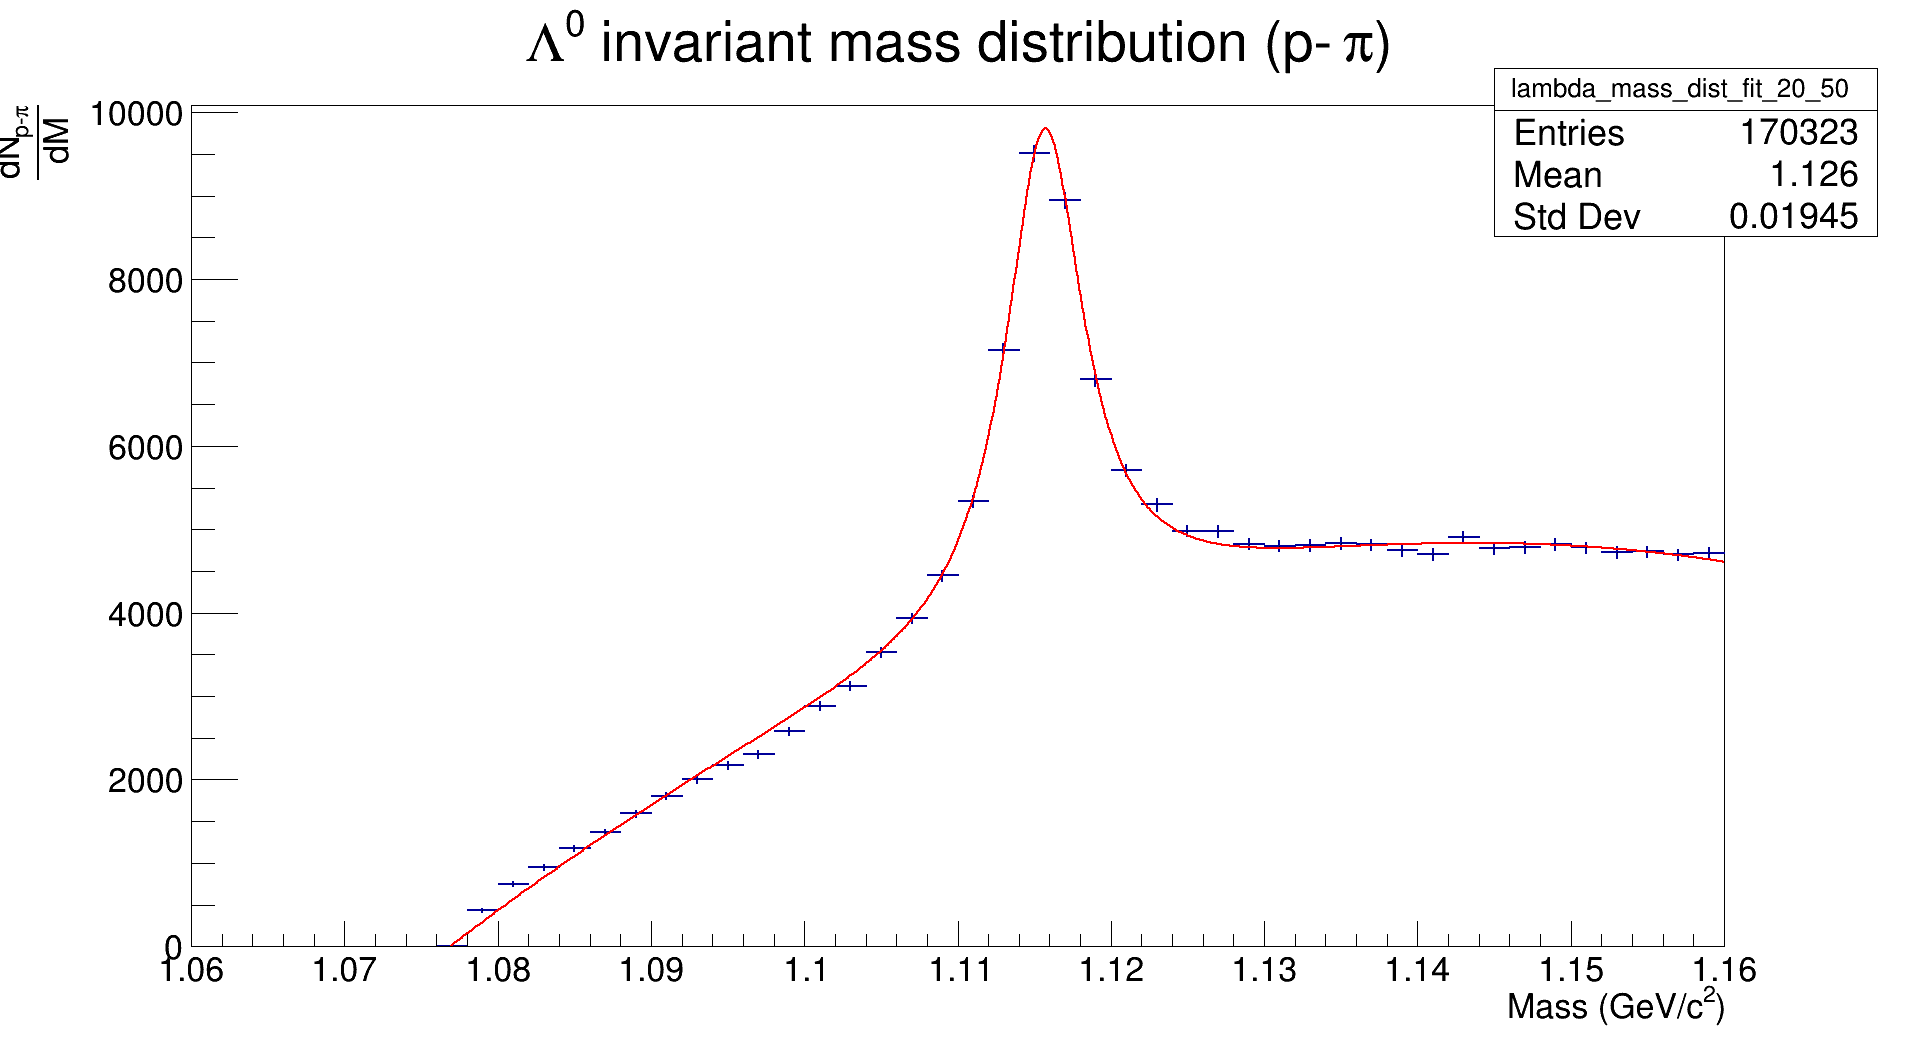

In [63]:
lambda_mass_dist_fit_20_50 = lambda_mass_dist_20_50.Clone("lambda_mass_dist_fit_20_50")
lambda_mass_dist_fit_20_50.Fit(lambda_mass_fit_20_50)
lambda_mass_dist_fit_20_50.Draw()
c.Draw()

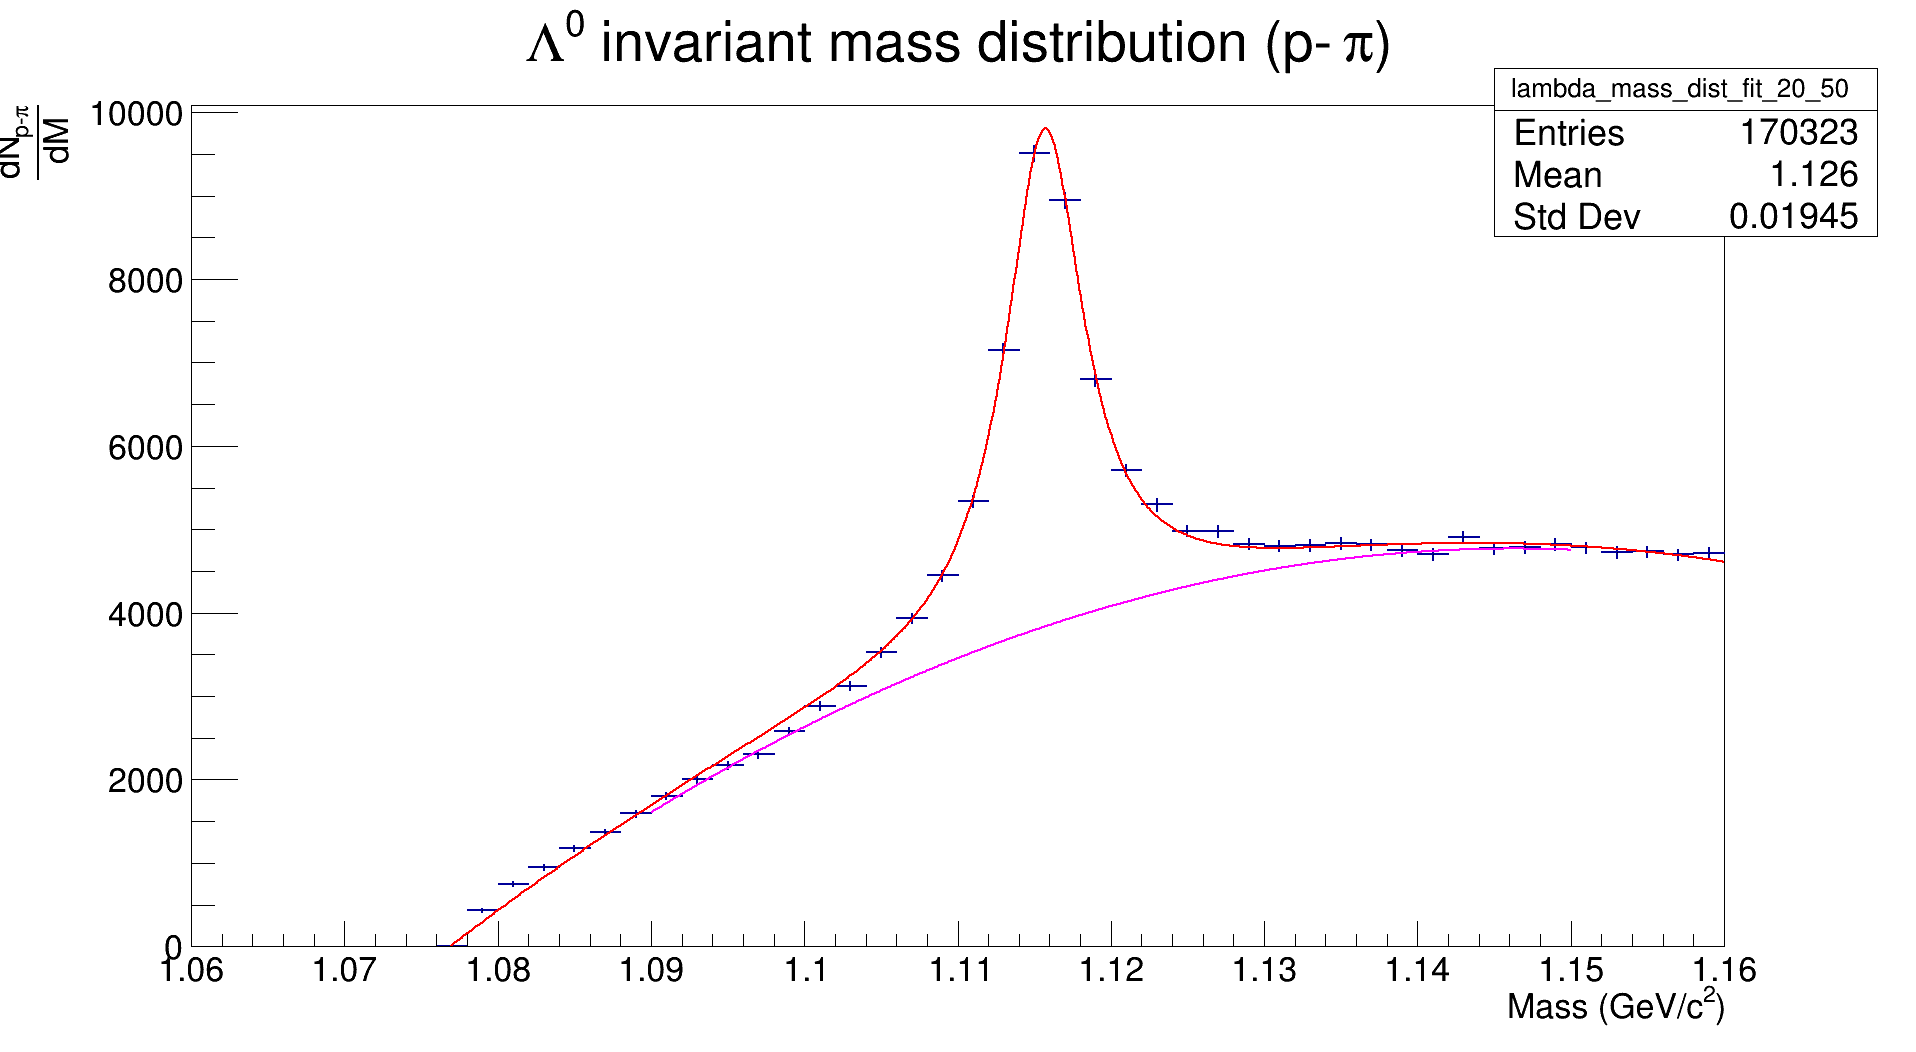

In [72]:
bg_fit_20_50 = rt.TF1("bg_fit_20_50", "pol2", 1.09, 1.15)
bg_fit_20_50.SetParameter(0, lambda_mass_fit_20_50.GetParameter(4))
bg_fit_20_50.SetParameter(1, lambda_mass_fit_20_50.GetParameter(5))
bg_fit_20_50.SetParameter(2, lambda_mass_fit_20_50.GetParameter(6))
bg_fit_20_50.SetNpx(1000)
bg_fit_20_50.SetLineColor(rt.kMagenta)
lambda_mass_dist_fit_20_50.Draw()
bg_fit_20_50.Draw("SAME")
c.Draw()

In [86]:
left_signal_bin_20_50 = 25
right_signal_bin_20_50 = 32

lambda_bg_20_50 = 0
lambda_total_20_50 = 0
for bin_num in range(left_signal_bin_20_50, right_signal_bin_20_50 + 1):
    bin_center = lambda_mass_dist_fit_20_50.GetBinCenter(bin_num)
    lambda_bg_20_50 += bg_fit_20_50.Eval(bin_center)
    lambda_total_20_50 += lambda_mass_dist_fit_20_50.GetBinContent(bin_num)

lambda_signal_20_50 = lambda_total_20_50 - lambda_bg_20_50
lambda_signal_total_ratio_20_50 = lambda_signal_20_50/lambda_total_20_50
lambda_signal_bg_ratio_20_50 = lambda_signal_20_50/lambda_bg_20_50
print(f"The 20-50 lambda signal is: {lambda_signal_20_50}")
print(f"The 20-50 lambda background is: {lambda_bg_20_50}")
print(f"The 20-50 lambda S/B is: {lambda_signal_bg_ratio_20_50}")
print(f"The 20-50 lambda S/T is: {lambda_signal_total_ratio_20_50}")
print(f"The 20-50 lambda significance is: {lambda_signal_20_50/math.sqrt(lambda_signal_20_50 + lambda_bg_20_50)}")

The 20-50 lambda signal is: 22555.676052338444
The 20-50 lambda background is: 30662.323947661556
The 20-50 lambda S/B is: 0.7356153464049041
The 20-50 lambda S/T is: 0.42383547018562223
The 20-50 lambda significance is: 97.77471843476432


In [87]:
axes = arr.array('i', [2, 3, 4, 5])

NameError: name 'arr' is not defined

# 50 - 80 setup

In [ ]:
input_file_cent_50_80 = rt.TFile("../online/output/cent_50_80.root")